# Determining Buzz Words on Reddit



If there were a website that was basically 'the internet' in nutshell, it's Reddit. Reddit is a social media website with a distinct forum-like style. The website is broken into smaller, more specific sites called subreddits. Each subreddit has its own theme or topic for discussion. It can feel like navigating a jungle trying to find the right subreddit, but if you can imagine one it almost certainly exists.

'Hot' posts are at the front and center of a given subreddit. 'Hotness' is determined by both a post's score (upvotes minus downvotes) and how recent the post is. Reddit has this system to constantly cycle old posts out and new posts in so that the site does not stagnate for too long. But for every popular post, there are dozens of unpopular ones that most people never see. This begs the question: is there a pattern between posts' word choice and how much karma that post receives?

Information like this about a subreddit is important for ad companies to know how to target their ads. You shouldn't be posting an ad for Budweiser on r/stopdrinking or r/addiction. And knowing 'buzz words' can give an ad an edge; take for instance a gaming subreddit like r/league. Corporations may or may not be familiar with the latest gamer lingo so expanding their vocabulary is essential to get their message to an audience that tends to roll their eyes at ads.

To get started, we will need to be able to access Reddit using its API, PRAW.
More details can be found here: https://praw.readthedocs.io/en/latest/getting_started/quick_start.html

In [438]:
!pip3 install praw

In [242]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as BSoup
import re
import seaborn as sns
import sklearn.feature_extraction as skfeat
import matplotlib as plt

In [47]:
import praw

Here is where we will need PRAW. Using this on your own requires that you first set up a Reddit account and then create an app on their developers' page. But for now, this tutorial will use an app I created on a burner account. The code below does not contain personal information as it does not submit any requests to the server that are specific to an account. An extension to this tutorial using account login info might involve creating a bot to automatically post/update information to Reddit. Perhaps with more machine learning, those posts could even be constructed from the set of popular words for a particular subreddit.

In [94]:
#NOTE: not logged in with an account but this code accesses an app attached to a throwaway acc.
reddit = praw.Reddit(client_id="WIBYrJVVYt3WMQ", client_secret="8rbRMd75jk0VfuYpAVxkEIlxUSwm0A", user_agent="PostGetter")

First, let's try looking at some figures from r/all.
Again, PRAW API can be found here: https://praw.readthedocs.io/en/latest/getting_started/quick_start.html
Here, I need to get the data from Reddit into a DataFrame. There is a way to do this without creating the variable "hot_data", but it is more time-efficient to create a DataFrame from a large array of dicts than it is to create it once and append each hot post one-at-a-time. Posts are referred to as 'submissions' in the API. Good data points to collect are 'title', 'score', and 'timestamp' for this investigation.

In [443]:
hot_posts = reddit.subreddit("all").hot(limit=200)

hot_data = []
i = 0
for post in hot_posts:
    #d_votes = int(post.score*(1-post.upvote_ratio)/(2*post.upvote_ratio-1) + 0.5)
    hot_data.append({"title":post.title,"score":post.score, #"upvotes":post.score+d_votes, "downvotes":d_votes,
                   "upvoteRatio":post.upvote_ratio,
                   "timestamp":pd.Timestamp(post.created_utc, unit="s"), 
                   "numComments":post.num_comments, "subreddit":post.subreddit})
    i += 1
hot_df = pd.DataFrame.from_dict(hot_data)
hot_df.head()

,title,score,upvoteRatio,timestamp,numComments,subreddit
0,Kelly Loeffler says she uses private jet to sa...,12884,0.97,2020-12-21 11:37:49,428,politics
1,3 Dogs 1 Cat,28738,0.98,2020-12-21 10:38:44,273,aww
2,Russian opposition leader Alexey Navalny dupes...,7067,0.98,2020-12-21 12:14:53,267,worldnews
3,The concept of light pollution is crazy,59310,0.96,2020-12-21 09:30:35,1299,interestingasfuck
4,That’s a big full brother,16439,0.94,2020-12-21 10:48:55,59,PrequelMemes


If you did it right, it should look something like this. Note that `created_utc` is in seconds and that NSFW posts *might* get in the top 200 posts. I didn't care to here but you can filter them out by checking each post for `over_18`. If you need the total number of votes on a post, you can calculate upvotes and downvotes by the following:

`downvotes = score * (1 - ratio)/(2 * ratio - 1)`

`upvotes = score + downvotes`

`total votes = downvotes+upvotes`

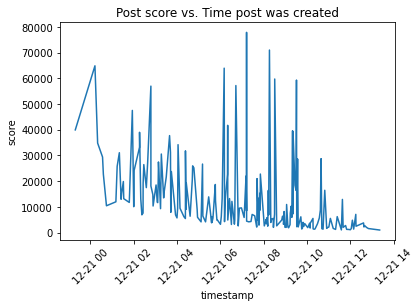

In [461]:
ax = sns.lineplot(data=hot_df, x="timestamp", y="score")
ax.set_title("Post score vs. Time post was created")
ax.tick_params(axis='x', labelrotation=45)

The plot above is a quick post score over time plot. Note that the x-axis is in UTC/UK Greenwich time. This can be avoided by modifying the timestamp constructor to add `tz = "[timezone]"`

Text(0.5, 1.0, 'Number of characters in title vs. Post score')

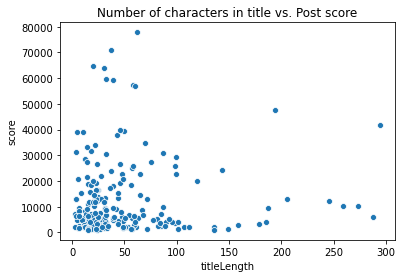

In [462]:
hot_df["titleLength"] = hot_df["title"].apply(lambda x:len(x))
sns.scatterplot(data=hot_df, x="titleLength", y="score").set_title("Number of characters in title vs. Post score")

This plot shows a correlation between title length and score. The data appears to take an 'L'-shape meaning that most 'hot' posts with long titles are generally not likely to have as high of a score as posts with short titles. It's a bit faint, but it also appears to have a negative corellation between title length and post score. 
This also shows that the majority of 'hot' posts have short titles (1-100 characters).

## r/Eyebleach

~~r/Aww is a subreddit dedicated to cute pictures. The popular joke about 'cat pictures on the internet' can probably be blamed on this subreddit. That being said, this sub will be a good example for how to (roughly) get the most popular terms on a given subreddit. The subreddit is primarily an image board so the titles will mostly be short, and there is a good chance many of the posts are similar to one another so they end up using the same words.~~

Post-project note: r/Aww is an absolutely terrible subreddit for reasons you can discover by looking at comments of some posts. r/Eyebleach is better for *ethically-sourced* cute pictures, so we will be using posts from that subreddit instead.

First, let's get the top posts in a very similar way as before, except now grabbing the comments for later. Avoid stickied posts since they aren't 'hot' and toss everything into a DataFrame.

In [475]:
eb_posts = reddit.subreddit("Eyebleach").hot(limit=200)

eb_data = []
i = 0
for post in eb_posts:
    if(not post.stickied):
        eb_data.append({"title":post.title,"score":post.score,
                   "upvoteRatio":post.upvote_ratio,
                   "timestamp":pd.Timestamp(post.created_utc, unit="s"), 
                   "numComments":post.num_comments, "topComments":post.comments[0:5]})
    i += 1
eb_df = pd.DataFrame.from_dict(eb_data)
eb_df.head()

,title,score,upvoteRatio,timestamp,numComments,topComments
0,Just a little hamster enjoying some snacks in ...,19256,0.98,2020-12-21 04:23:03,67,"[ggk6rcs, ggka2rh, ggk6w8c, ggk7kul, ggk9r5n]"
1,The perfect spot,1186,0.99,2020-12-21 11:57:01,14,"[ggkz37z, ggkwdej, ggkxiha, ggl2pnc, ggl10x7]"
2,Cutest wild kitten,728,0.99,2020-12-21 10:55:02,11,"[ggkrbdf, ggl6xjq, ggkr5do, ggkwran, ggl8cje]"
3,The dog sheltered little kittens,29976,0.97,2020-12-20 19:09:26,94,"[ggipc24, ggj42fq, ggiqu2r, ggja9q4, ggjc3c7]"
4,"Meet Kiddo, any love for mixed dogs?",481,0.99,2020-12-21 10:28:18,26,"[ggkq1nn, ggkpmza, ggkqttg, ggkr28v, ggkugnu]"


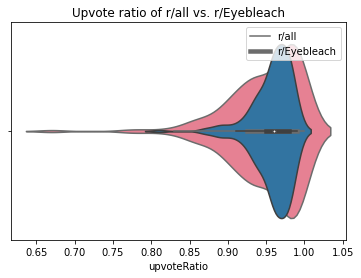

In [479]:

ax = sns.violinplot(data=eb_df, x="upvoteRatio", palette="husl", alpha=0.5)
ax = sns.violinplot(data=hot_df, x="upvoteRatio", alpha=0.5)
ax.set_title("Upvote ratio of r/all vs. r/Eyebleach")
ax.legend(["r/all", "r/Eyebleach"])

Above is a plot of the upvote ratios for both r/Eyebleach and r/all. Matplotlib is being disagreeable and it is portraying the legend with the colors of the lines in the middle rather than the colors of the violins themselves. Pink is r/Eyebleach and blue is r/all.

Next is r/Eyebleach vs. r/Aww, just to show the difference in upvote ratio

In [540]:
aww_posts = reddit.subreddit("aww").hot(limit=200)

aww_data = []
i = 0
for post in aww_posts:
    if(not post.stickied):
        aww_data.append({"title":post.title,"score":post.score,
                   "upvoteRatio":post.upvote_ratio,
                   "timestamp":pd.Timestamp(post.created_utc, unit="s"), 
                   "numComments":post.num_comments, "topComments":post.comments[0:5]})
    i += 1
aww_df = pd.DataFrame.from_dict(aww_data)
aww_df.head()

,title,score,upvoteRatio,timestamp,numComments,topComments
0,Hard to get all those wrinkles out of the sheets,28810,0.96,2020-12-21 11:23:23,416,"[ggkw9lh, ggkvio3, ggku47w, ggkvqx2, ggkvuhr]"
1,3 Dogs 1 Cat,65550,0.96,2020-12-21 10:38:44,542,"[ggkq34t, ggktl5d, ggku306, ggkvb25, ggktp6k]"
2,They got a pup from the shelter. This was the ...,5503,0.98,2020-12-21 13:17:07,40,"[ggl7qsi, ggln90t, ggldflx, ggl6n8v, ggl7dza]"
3,Fluff,16972,0.98,2020-12-21 09:57:32,89,"[ggkq31r, ggkt7rq, ggkupe5, ggkntw6, ggkx1b5]"
4,Doggo in its natural habitat,10535,0.99,2020-12-21 09:39:49,76,"[ggkok0l, ggkwwcc, ggks5qu, ggl5m5c, ggkosjm]"


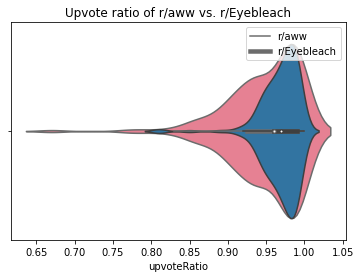

In [483]:
ax = sns.violinplot(data=eb_df, x="upvoteRatio", palette="husl", alpha=0.5)
ax = sns.violinplot(data=aww_df, x="upvoteRatio", alpha=0.5)
ax.set_title("Upvote ratio of r/aww vs. r/Eyebleach")
ax.legend(["r/aww", "r/Eyebleach"])

Again, pink is r/Eyebleach but blue ir r/aww. The two subreddits appear to have similar statistics as to how often users in each tend to upvote/downvote posts. However, r/aww has had an issue with bots farming karma on the subreddit recently, and looking at how narrow the upvote ratio is, it certainly could be possible. These are two subreddits with almost the exact same purpose, yet one has a wider distribution than the other. Not to mention how overwhelmingly negative the *top* responses are to some of the posts on r/Eyebleach... it's very fishy. To be safe, I am using r/Eyebleach moving forward.

In any case, next let's convert the comment IDs into comment text. You can refit this to use more than 5 comments per post, but it will take longer to run. I'm also getting the comment's score while I'm at it.

In [484]:
eb_df = eb_df[["title", "score", "numComments", "topComments"]]
# eb_comments["topComments"].apply(lambda x: x)
for i in range(5):
    eb_df["Comment "+str(i+1)+" Text"] = eb_df["topComments"].apply(lambda x: np.nan if not len(x) > i else x[i].body)
    eb_df["Comment "+str(i+1)+" Score"] = eb_df["topComments"].apply(lambda x: np.nan if not len(x) > i else x[i].score)
eb_df = eb_df.drop("topComments", axis=1)
eb_df.head()


,title,score,numComments,Comment 1 Text,Comment 1 Score,Comment 2 Text,Comment 2 Score,Comment 3 Text,Comment 3 Score,Comment 4 Text,Comment 4 Score,Comment 5 Text,Comment 5 Score
0,Just a little hamster enjoying some snacks in ...,19256,67,Me_irl,147.0,What a cute little niblet!,70.0,monch,41.0,This has to be the most cute you can pack in b...,53.0,Can I please order a cup of hamster?,28.0
1,The perfect spot,1186,14,"*If I fits, I sits.*",33.0,That’s adorable,11.0,Is that at an optometrist or something? What'...,12.0,I found out that dogs and cats can get along j...,5.0,This is my dream,5.0
2,Cutest wild kitten,728,11,Ocelot?,5.0,Babou?!,3.0,Good thing he's not any bigger! He looks sooo...,1.0,Furfect,1.0,Rawr!,1.0
3,The dog sheltered little kittens,29976,94,Huskies can be very cat-like.,560.0,"""These are my puppies. They are strange and me...",428.0,That's a big kitten,184.0,I want the one that looks like he had a piece ...,201.0,“Alright you all are going to be the meanest p...,103.0
4,"Meet Kiddo, any love for mixed dogs?",481,26,Uh that's a fox not a dog. Super cute!,40.0,"ALL the love for mixed dogs. Healthier, more v...",23.0,She looks like the most wonderful mix between ...,7.0,F o x g o b r r,6.0,That's an American dingo ! I have one too!,3.0


Now for the fun part. Here is a Bag of Words/BOW using sklearn's count vectorizer (see more: https://scikit-learn.org/stable/modules/feature_extraction.html). The gist is that we need to fit the post titles to get a matrix of how many times a each word appears in each post. I'd recommend for the sake of convenience to use `stop_words='english'` to prevent words like 'the' from getting in.

For now, we will only be using post titles. Comments work the exact same way though, just with code to get all 5 columns. `eb_word_counts` is what we want: each word associated with how many times the word appears in all the post titles.

In [507]:
vectorizer = skfeat.text.CountVectorizer(stop_words="english")

X = vectorizer.fit_transform(eb_df["title"])
# vectorizer.build_analyzer()
#vectorizer.get_feature_names()

eb_word_counts = {word: sum(X.toarray()[:,vectorizer.vocabulary_.get(word)]) for word in vectorizer.get_feature_names()}
eb_word_counts

{'11': 1,
 '14': 1,
 '16yo': 1,
 '18': 1,
 '1950': 1,
 '1st': 1,
 'additions': 1,
 'adopted': 2,
 'aesthetic': 1,
 'aide': 1,
 'albus': 1,
 'apart': 1,
 'asleep': 1,
 'attack': 1,
 'australia': 1,
 'autumn': 1,
 'away': 2,
 'baby': 3,
 'ball': 2,
 'barn': 2,
 'barnabas': 1,
 'barren': 1,
 'bath': 2,
 'beach': 1,
 'beautiful': 2,
 'bed': 1,
 'beneath': 1,
 'bernardo': 1,
 'best': 4,
 'big': 1,
 'bike': 1,
 'bit': 3,
 'blanket': 2,
 'blankie': 1,
 'blem': 1,
 'blind': 1,
 'blue': 1,
 'boi': 2,
 'born': 1,
 'boy': 2,
 'brightens': 1,
 'bring': 1,
 'brings': 1,
 'broom': 1,
 'brother': 1,
 'brothers': 1,
 'buddies': 1,
 'buddy': 1,
 'bulldog': 1,
 'bun': 1,
 'bunny': 3,
 'burrito': 1,
 'cake': 1,
 'cakeday': 1,
 'card': 1,
 'care': 1,
 'caring': 1,
 'cat': 15,
 'catch': 1,
 'catnap': 1,
 'catnip': 2,
 'cats': 2,
 'caught': 2,
 'chameleon': 2,
 'change': 1,
 'character': 1,
 'check': 1,
 'chester': 1,
 'chewbug': 1,
 'china': 1,
 'christmas': 13,
 'chubby': 1,
 'circa': 1,
 'circles': 1,
 '

Next we'll do a quick filter to get rid of the irrelevant terms.

In [508]:
eb_word_counts = {k: v for k,v in eb_word_counts.items() if re.compile("[a-zA-Z]").match(k)}
#Docs list 're and 've like in you're and we've as not removed
if "re" in eb_word_counts:
    eb_word_counts.pop("re")
if "ve" in eb_word_counts:
    eb_word_counts.pop("ve")
eb_word_counts

{'additions': 1,
 'adopted': 2,
 'aesthetic': 1,
 'aide': 1,
 'albus': 1,
 'apart': 1,
 'asleep': 1,
 'attack': 1,
 'australia': 1,
 'autumn': 1,
 'away': 2,
 'baby': 3,
 'ball': 2,
 'barn': 2,
 'barnabas': 1,
 'barren': 1,
 'bath': 2,
 'beach': 1,
 'beautiful': 2,
 'bed': 1,
 'beneath': 1,
 'bernardo': 1,
 'best': 4,
 'big': 1,
 'bike': 1,
 'bit': 3,
 'blanket': 2,
 'blankie': 1,
 'blem': 1,
 'blind': 1,
 'blue': 1,
 'boi': 2,
 'born': 1,
 'boy': 2,
 'brightens': 1,
 'bring': 1,
 'brings': 1,
 'broom': 1,
 'brother': 1,
 'brothers': 1,
 'buddies': 1,
 'buddy': 1,
 'bulldog': 1,
 'bun': 1,
 'bunny': 3,
 'burrito': 1,
 'cake': 1,
 'cakeday': 1,
 'card': 1,
 'care': 1,
 'caring': 1,
 'cat': 15,
 'catch': 1,
 'catnap': 1,
 'catnip': 2,
 'cats': 2,
 'caught': 2,
 'chameleon': 2,
 'change': 1,
 'character': 1,
 'check': 1,
 'chester': 1,
 'chewbug': 1,
 'china': 1,
 'christmas': 13,
 'chubby': 1,
 'circa': 1,
 'circles': 1,
 'class': 1,
 'claws': 1,
 'clay': 1,
 'climb': 1,
 'cold': 1,
 'co

Now, let's plot the most popular terms in r/Eyebleach.

Text(0.5, 1.0, 'Most popular Words on r/Eyebleach (5+ uses)')

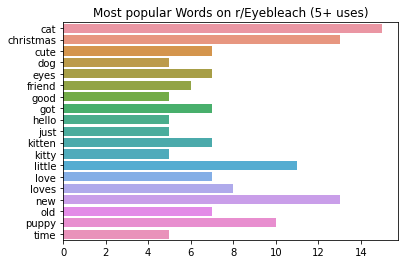

In [509]:
high_temp_counts = {k:v for k, v in eb_word_counts.items() if v > 4}
# ax = plt.pyplot.barh(y=[k for k in range(len(max_temp_counts))],
#                     width=max_temp_counts.values(), tick_label=[k for k in max_temp_counts.keys()])

# sns.barplot(x=eb_word_counts.keys(), y=eb_word_counts.values)
sns.barplot(y=[k for k in high_temp_counts.keys()], x=[v for v in high_temp_counts.values()], orient="h").set_title("Most popular Words on r/Eyebleach (5+ uses)")

And again, for good measure:

Text(0.5, 1.0, 'Most popular terms on r/Eyebleach (8+ uses)')

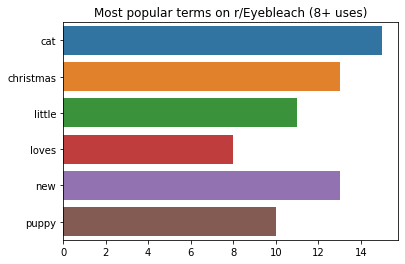

In [510]:
max_temp_counts = {k:v for k, v in eb_word_counts.items() if v > 7}
# ax = plt.pyplot.barh(y=[k for k in range(len(max_temp_counts))],
#                     width=max_temp_counts.values(), tick_label=[k for k in max_temp_counts.keys()])

# sns.barplot(x=eb_word_counts.keys(), y=eb_word_counts.values)
sns.barplot(y=[k for k in max_temp_counts.keys()], x=[v for v in max_temp_counts.values()], orient="h").set_title("Most popular terms on r/Eyebleach (8+ uses)")

At the current date and time, it appears 'cat', 'christmas', 'little', 'puppy', and 'new' are all pretty common words.
This is to be expected, after all that's what the subreddit is about. Unfortunately, there is no way to tell what is in the images themselves without an advanced algorithm trained to differentiate between cats and dogs, but this is a good place to start. 

On this particular subreddit, the most popular words do not mean a whole lot since they are fairly predictable. Next, let's try and see how 'sophisticated' the vocabulary of r/Eyebleach users is. Note that this takes from all the words, not the most popular ones.

Text(0, 0.5, 'Occurences')

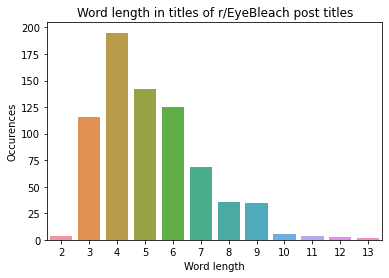

In [512]:
temp_len_counts = {len(k):0 for k in eb_word_counts.keys()}
for k, v in eb_word_counts.items():
    temp_len_counts[len(k)] += v
temp_len_counts = {k:temp_len_counts[k] for k in sorted(temp_len_counts)}
temp_len_counts

# plt.pyplot.hist(x=[k for k in temp_len_counts.keys()], bins=1, orientation="horizontal")
# ax = plt.pyplot.barh(y=[k for k in range(len(temp_len_counts))],
#                     width=temp_len_counts.values(), tick_label=[k for k in temp_len_counts.keys()])
ax = sns.barplot(x=[k for k in temp_len_counts.keys()], y=[v for v in temp_len_counts.values()])
ax.set_title("Word length in titles of r/EyeBleach post titles")
ax.set_xlabel("Word length")
ax.set_ylabel("Occurences")

Generally, it appears that words have ~4 letters in them.
We don't have any frame of reference, so let's use r/Science to show a clear disparity. The following few cells repeat all the same steps as before but with a new subreddit.

In [513]:
sci_posts = reddit.subreddit("science").hot(limit=200)

sci_data = [] #[None for i in range(50)]
i = 0
for post in sci_posts:
    if(not post.stickied):
        sci_data.append({"title":post.title,"score":post.score,
                   "upvoteRatio":post.upvote_ratio,
                   "timestamp":pd.Timestamp(post.created_utc, unit="s"), 
                   "numComments":post.num_comments, "topComments":post.comments[0:5]})
    i += 1
sci_df = pd.DataFrame.from_dict(sci_data)
sci_df.head()

,title,score,upvoteRatio,timestamp,numComments,topComments
0,Quarter of world may not have access to COVID-...,14932,0.94,2020-12-21 09:17:36,784,"[ggkle1a, ggky0v7, ggkyfxx, ggkyxcx, ggkvw3q]"
1,The COVID-19 pandemic masks the way people per...,1721,0.92,2020-12-21 10:36:25,255,"[ggkpvh6, ggkq8sw, ggkupfp, ggks23i, ggkxal4]"
2,Republican lawmakers vote far more often again...,313,0.88,2020-12-21 15:49:20,36,"[gglf0rw, ggliv1v, ggljumt, gglka0y, gglm567]"
3,New study links psychopathic tendencies to rac...,51631,0.62,2020-12-20 20:57:41,3967,"[ggimj6v, ggixp8z, ggj1p1r, ggk9xru, ggiznsw]"
4,"Alligators can regrow severed tails, surprisin...",161,0.95,2020-12-21 13:05:19,25,"[ggkzeqk, ggl4jlt, ggl49xv, ggl7fzd, gglg8ee]"


In [518]:
vec2 = skfeat.text.CountVectorizer(stop_words="english")

X2 = vec2.fit_transform(sci_df["title"])
# vectorizer.build_analyzer()
#vectorizer.get_feature_names()

sci_wc = {word: sum(X2.toarray()[:,vec2.vocabulary_.get(word)]) for word in vec2.get_feature_names()}


sci_wc = {k: v for k,v in sci_wc.items() if v > 1 and re.compile("[a-zA-Z]").match(k)}
#Docs list 're and 've like in you're and we've as not removed
if "re" in sci_wc:
    sci_wc.pop("re")
if "ve" in sci_wc:
    sci_wc.pop("ve")

sci_lens = {len(k):0 for k in sci_wc.keys()}
for k, v in sci_wc.items():
    sci_lens[len(k)] += v
sci_lens = {k:sci_lens[k] for k in sorted(sci_lens)}

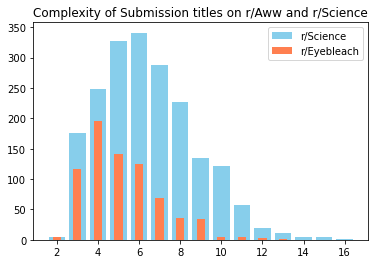

In [519]:
f, ax = plt.pyplot.subplots()

plt.pyplot.bar(x=[k for k in sci_lens.keys()], height=[v for v in sci_lens.values()], color="skyblue")
plt.pyplot.bar(x=[k for k in temp_len_counts.keys()], height=[v for v in temp_len_counts.values()], width=0.4, color="coral")

ax.set_title("Complexity of Submission titles on r/Aww and r/Science")
plt.pyplot.legend(["r/Science", "r/Eyebleach"])

So here's what the data shows: r/Eyebleach has fewer words as indicated by the shorter bars, and r/Science has more words and is centered around a word length of ~6.

In [ ]:
aww_df = aww_df[["title", "score", "numComments", "topComments"]]
# aww_comments["topComments"].apply(lambda x: x)
for i in range(5):
    aww_df["Comment "+str(i+1)+" Text"] = aww_df["topComments"].apply(lambda x: np.nan if not len(x) > i else x[i].body)
    aww_df["Comment "+str(i+1)+" Score"] = aww_df["topComments"].apply(lambda x: np.nan if not len(x) > i else x[i].score)
aww_df = aww_df.drop("topComments", axis=1)

In [543]:
aww_df.head()

,title,score,numComments,Comment 1 Text,Comment 1 Score,Comment 2 Text,Comment 2 Score,Comment 3 Text,Comment 3 Score,Comment 4 Text,Comment 4 Score,Comment 5 Text,Comment 5 Score
0,Hard to get all those wrinkles out of the sheets,28810,416,So many cats yet no worrys about cat hair.,1963.0,"I can’t make the bed with ONE cat in the room,...",466.0,What playful little skinned demons you have!,287.0,You leave those wrinkles alone! They're just t...,211.0,I love the lil simultaneous pounce when she pu...,139.0
1,3 Dogs 1 Cat,65550,542,Look at how gently they insert themselves into...,3574.0,"This is cut too soon, I need to see the doggo ...",1711.0,I love this. When I was growing up my parents ...,493.0,"We had two golden retrievers, and an old, cant...",140.0,That bed looks warm,132.0
2,They got a pup from the shelter. This was the ...,5503,40,Shelter dogs (and cats) just appreciate things...,117.0,My roommates and I have been fostering doggos ...,17.0,No one can convince me that animals don't have...,22.0,Damn that a good boi,8.0,I hope the pup will live a happy and fulfilled...,7.0
3,Fluff,16972,89,What eyeliner does she use?,349.0,This cat is still prettier than me even during...,88.0,What is that purple band all about?,103.0,"Not fat, just fluffy",76.0,I never saw a cat with eyes that big,35.0
4,Doggo in its natural habitat,10535,76,Liondog,112.0,This looks like a scene from a movie where the...,59.0,"Oh no, put a wool sock on his left paw, it’s c...",67.0,"I have a snow dog as well. Different breed, an...",17.0,"Greetings human, I am ice dog",33.0


And here's another quick demonstration, this time just for top comments:

Text(0.5, 1.0, 'Most popular Words on r/Eyebleach Comments (5+ uses)')

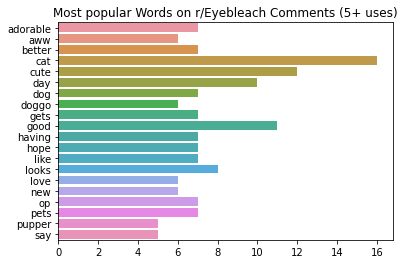

In [555]:
vec3 = skfeat.text.CountVectorizer(stop_words="english")

X3 = vec3.fit_transform(eb_df[eb_df["Comment 1 Text"].notna()]["Comment 1 Text"])
# vectorizer.build_analyzer()
#vectorizer.get_feature_names()

eb_wc = {word: sum(X3.toarray()[:,vec3.vocabulary_.get(word)]) for word in vec3.get_feature_names()}


eb_wc = {k: v for k,v in eb_wc.items() if v > 1 and re.compile("[a-zA-Z]").match(k)}
#Docs list 're and 've like in you're and we've as not removed
if "re" in eb_wc:
    eb_wc.pop("re")
if "ve" in eb_wc:
    eb_wc.pop("ve")

eb_lens = {len(k):0 for k in eb_wc.keys()}
for k, v in eb_wc.items():
    eb_lens[len(k)] += v
eb_lens = {k:eb_lens[k] for k in sorted(eb_lens)}

high_temp_counts2 = {k:v for k, v in eb_wc.items() if v > 4}
# ax = plt.pyplot.barh(y=[k for k in range(len(max_temp_counts))],
#                     width=max_temp_counts.values(), tick_label=[k for k in max_temp_counts.keys()])

# sns.barplot(x=eb_word_counts.keys(), y=eb_word_counts.values)
sns.barplot(y=[k for k in high_temp_counts2.keys()], x=[v for v in high_temp_counts2.values()], orient="h").set_title("Most popular Words on r/Eyebleach Comments (5+ uses)")

About what you'd expect for a crowd of people looking at something cute.

For the next one, let's see how using the word 'cute' in the title correlates with the score of the post. Most terms do not show much correlation, but in this case it works.

Text(0.5, 1.0, "Post score vs. usage of 'cute' in a post's title")

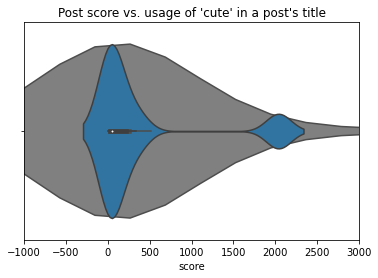

In [581]:
sns.violinplot(x=eb_df["score"], color="grey", bw=0.2)
ax = sns.violinplot(x=eb_df[eb_df["title"].apply(lambda x: "cute" in x)]["score"], bw=0.2)
ax.set_xlim([-1000,3000])
ax.set_title("Post score vs. usage of \'cute\' in a post\'s title")

There is a notable group of outliers to the right. Those ones must be truly 'cute'.

## Conclusion

It seems like most of the results are to be expected. You can use this technique on any subreddit to get a picture of what the conversation is usually about, and what words may increase your chances of your posts being noticed. 

This is the kind of data advertisers might be interested in using, especially on reddit where ads blend in with other content very well. Data can also be obtained in a similar way to try to discover new words (If you look at the r/Eyebleach comments bar chart, many replies use colloquial words such as 'op' and 'pupper') or even to train a model to learn a dialogue-like English. 

Another important application of this technology is security. Certain normal words may be 'buzz words' in underground subreddits featuring illegal content. There won't always be eyes in dark corners, so using a bot to pick up on a popular word (i.e., 'cheese pizza/cp' is a well-known euphemism for 'child porn') can alert Reddit or authorities about illegal activity. Consequently, this also means that some users can use this technology to bombard subreddits with computer-generated posts to farm karma based on 'buzz words' alone. For instance, just auto-replying the Comment "Cute!" to r/Eyebleach might get some users free karma -- but it's also worth noting there are far more efficient ways to farm karma and these cons do not outweigh the pros. Regardless, word usage is important data for analytics and should be used responsibly. For the average-case user curious about data science and Reddit trends, this tutorial should be a good place to start.